#  Forecasting the number of sold for Indian spices  
We will forecast the number of sold goods in the city of Bangalore (India)

## 1. Подготовительный этап

### 1.1 Импорт библиотек, данных

In [70]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from etna.datasets.tsdataset import TSDataset
from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [37]:
# sales data in India in various cities and states
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

df.date = pd.DatetimeIndex(df.date)

# sort and add date to the index
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [38]:
# we need only 'quantity' column, drop another
df_bang = df.loc[df.city == "BANGALORE"].copy()

# df_bang column's names convert to drop list
drop_list = list(df_bang.columns)
drop_list.remove('quantity')
print(drop_list)

# drop columns
ts = df_bang.drop(drop_list, axis=1)
ts_clean = pd.DataFrame(ts.copy())

ts.head()

['market', 'month', 'year', 'priceMin', 'priceMax', 'priceMod', 'state', 'city', 'date']


,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


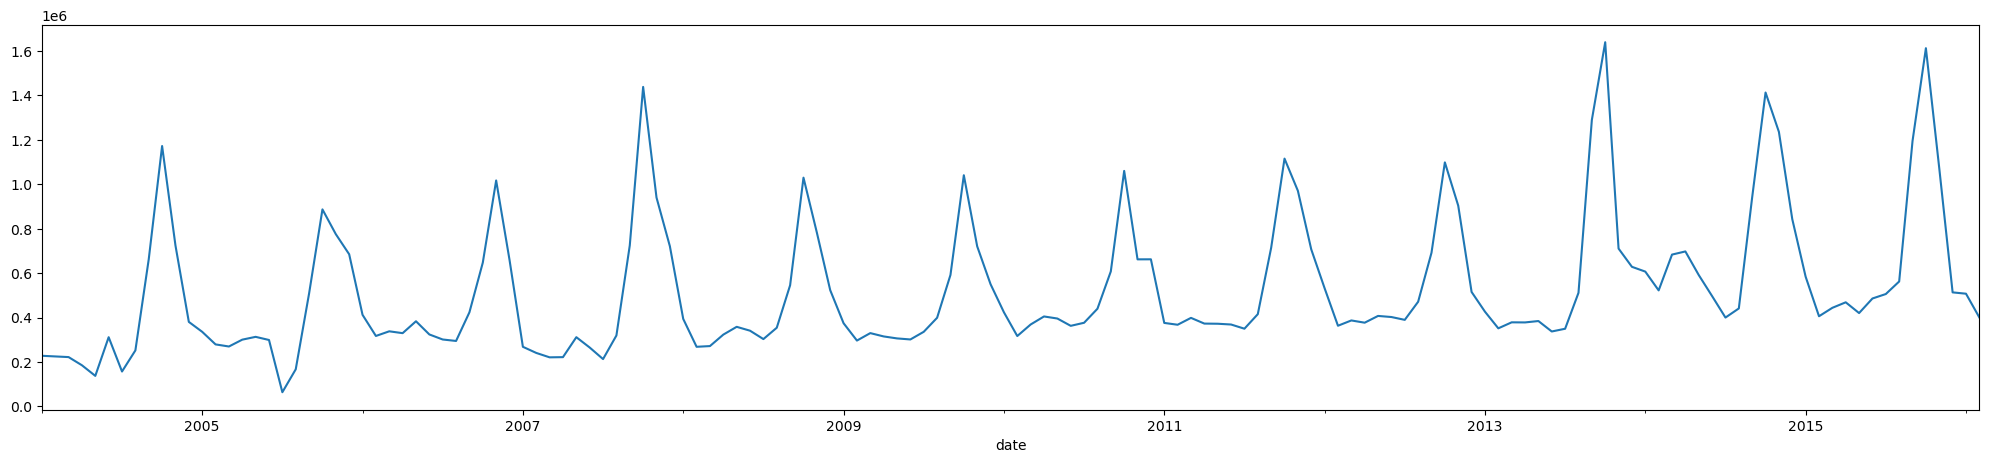

In [39]:
ts.quantity.plot(figsize=(25,5));

## 2. Data preprocessing

### 2.1 Create new TS features

In [40]:
# add lag features at first
for i in range(1, 8):
    ts[f"lag_{i}"] = ts.quantity.shift(i)

ts.dropna(inplace=True)
    
print(ts[1:12])

         quantity      lag_1      lag_2      lag_3      lag_4      lag_5  \
date                                                                       
2004-09    662382   251984.0   157022.0   311445.0   137390.0   185150.0   
2004-10   1171846   662382.0   251984.0   157022.0   311445.0   137390.0   
2004-11    724140  1171846.0   662382.0   251984.0   157022.0   311445.0   
2004-12    380379   724140.0  1171846.0   662382.0   251984.0   157022.0   
2005-01    335679   380379.0   724140.0  1171846.0   662382.0   251984.0   
2005-02    279047   335679.0   380379.0   724140.0  1171846.0   662382.0   
2005-03    269609   279047.0   335679.0   380379.0   724140.0  1171846.0   
2005-04    300428   269609.0   279047.0   335679.0   380379.0   724140.0   
2005-05    313052   300428.0   269609.0   279047.0   335679.0   380379.0   
2005-06    298906   313052.0   300428.0   269609.0   279047.0   335679.0   
2005-07     63824   298906.0   313052.0   300428.0   269609.0   279047.0   

           

### 2.2 Split train & test df

In [41]:
# split train and test
split_index = int(0.85*len(ts))

train = ts[:split_index]
test = ts[split_index:]

print(f'Train shape is {train.shape} and test shape is {test.shape}')

Train shape is (118, 8) and test shape is (21, 8)


In [42]:
# stand out X y
y_train = train['quantity']
y_test = test['quantity']

X_train = train.drop('quantity', axis=1)
X_test = test.drop('quantity', axis=1)

### 2.3 Create agregating features

Previously I used pivot tables to create aggregate attributes like average for the day, but now I found a way to do it more laconic.

In [43]:
# func create the dictionary with key - feature name, value - aggregated feature;
# so we can choose any categorical feature and apply to it some aggregation func;
# above we use it for mean value
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [44]:
# check it on month mean
ts['month'] = ts.index.month
mean_dict = code_mean(ts,'month','quantity')

display(mean_dict)

{1: 436629.0833333333,
 2: 344012.0,
 3: 371731.36363636365,
 4: 380720.8181818182,
 5: 385653.45454545453,
 6: 362042.2727272727,
 7: 326113.2727272727,
 8: 385456.6666666667,
 9: 741183.9166666666,
 10: 1179204.8333333333,
 11: 876030.3333333334,
 12: 615578.75}

## 3.0 Baseline

CPU times: user 17 ms, sys: 1.84 ms, total: 18.8 ms
Wall time: 18.6 ms


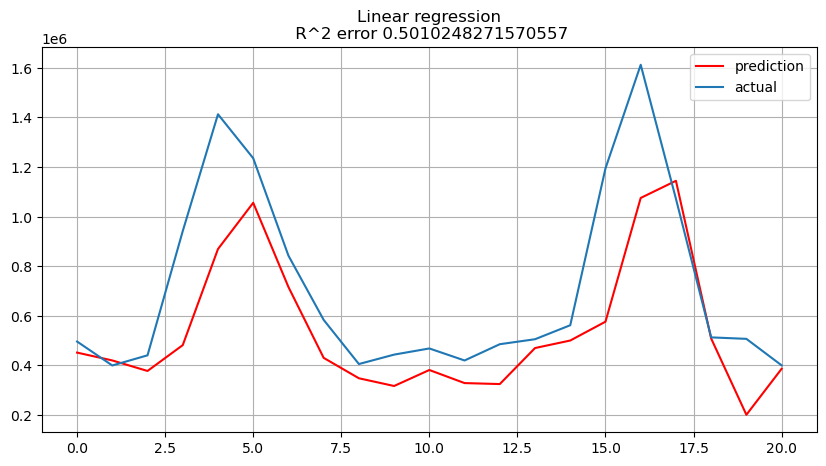

In [45]:
%%time

# declare the regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.grid(True)
plt.legend(loc='best')
plt.title(f'Linear regression\n R^2 error {r2_score(y_test,y_pred)}');

## 4. Model improvement

### 4.1 Add the average for the month

In [46]:
"""
In common case it will be:
ts['month_avg'] = list(map(code_mean(ts, 'month', 'quantity').get, ts.month))

1) split_index will prevent future data leaks;
2) get method method returns the value of the item with the specified key;
3) map applies code_mean func to ts.month;
"""

ts['month_avg'] = list(map(code_mean(ts.iloc[:split_index], 'month', 'quantity').get, ts.month))
ts.head()

,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,month,month_avg
date,,,,,,,,,,
2004-08,251984,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0,227832.0,8,362241.8
2004-09,662382,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0,9,675778.1
2004-10,1171846,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0,10,1112561.2
2004-11,724140,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0,11,820510.3
2004-12,380379,724140.0,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0,12,603110.6


### 4.2 Create special function for data preprocessing

In [47]:
def preprocess_data(data, lag_start=1, lag_end=8, split_index=split_index):
    data = pd.DataFrame(data.copy())

    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data['quantity'].shift(i)

    data = data.dropna()

    data['month'] = data.index.month

    data['month_avg'] = list(map(code_mean(data.iloc[:split_index], 'month', 'quantity').get, data.month))

    # name of the month we don't need any more, drop it
    data.drop(['month'], axis=1, inplace=True)

    # split the dataset to train and test
    X_train = data.iloc[:split_index].drop(['quantity'], axis=1)
    y_train = data.iloc[:split_index]['quantity']
    X_test = data.iloc[split_index:].drop(['quantity'], axis=1)
    y_test = data.iloc[split_index:]['quantity']

    return X_train, X_test, y_train, y_test

In [48]:
X_train, X_test, y_train, y_test = preprocess_data(ts_clean,1,12)

X_train.shape, X_test.shape

((118, 12), (17, 12))

### 4.3 Check the R^2 result

CPU times: user 9.25 ms, sys: 656 μs, total: 9.91 ms
Wall time: 9.43 ms


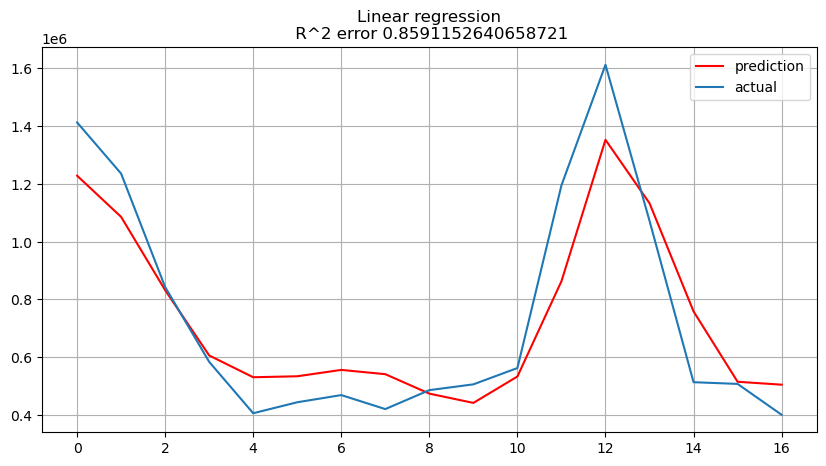

In [49]:
%%time

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, label='actual')
plt.grid(True)
plt.legend(loc='best')
plt.title(f'Linear regression\n R^2 error {r2_score(y_test,y_pred)}');

## 5. Try to use the ETNA library

The ETNA library was already installed in a virtual environment, if you execute the code in colab, you can use the command below:  
#!pip install etna -q

Note that at the time of writing the project the library supported Python <= 3.10, although 3.12 was already on the market.

We need to convert our existing data into the ETNA library format:  
* column `timestamp` - time at datetime format;  
* column `target` - target value (forecasting timeseries);  
* column `segment - main` if the target forecasting series is uniseries.



In [64]:
df_etna = df_bang.copy()

df_etna['timestamp'] = pd.to_datetime(df_etna['date'])
df_etna['target'] = df_etna['quantity']

drop_list = list(df_etna.columns)
drop_list.remove('timestamp')
drop_list.remove('target')

df_etna.drop(drop_list,axis=1,inplace=True)
df_etna['segment'] = 'main'
df_etna.reset_index(drop=True,inplace=True)

df_etna.head()

,timestamp,target,segment
0,2004-01-01,227832,main
1,2004-02-01,225133,main
2,2004-03-01,221952,main
3,2004-04-01,185150,main
4,2004-05-01,137390,main


ETNA has a special class for working with time series - TSDataset, let's bring our data to this format.

In [65]:
df_etna = TSDataset.to_dataset(df_etna)
# for ts frequency use pandas alias: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
ts_etna = TSDataset(df_etna, freq='MS')

display(ts_etna.head())
display(ts_etna.info())
display(ts_etna.describe())

segment,main
feature,target
timestamp,
2004-01-01,227832
2004-02-01,225133
2004-03-01,221952
2004-04-01,185150
2004-05-01,137390


<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2004-01-01    2016-02-01     146            0


None

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2004-01-01,2016-02-01,146,0,1,0,0,0,MS


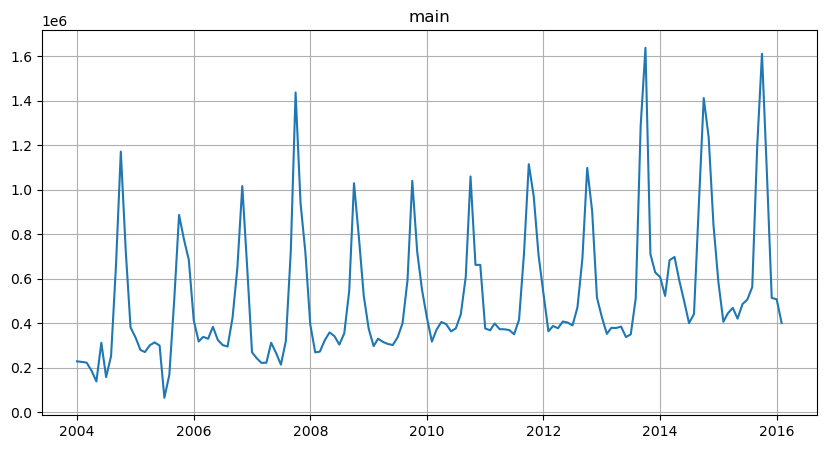

In [66]:
ts_etna.plot()

In [86]:
# split train and test
test_size = 0.15
split_index = round(len(df_etna.index.to_list())*(1-test_size))
display(split_index)

train_ts, test_ts = ts_etna.train_test_split(test_size=(len(df_etna)-split_index))

print(f'Number of train timestamps is {split_index} and number of test timestamps is {len(df_etna)-split_index}')

124

Number of train timestamps is 124 and number of test timestamps is 22
